<a href="https://colab.research.google.com/github/gmb408/OSSP-KBO-prediction/blob/version-0.1/Model_Building.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [95]:
# 데이터 분석 모듈
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime

In [96]:
# 출력 할 때 마다, 기존 출력물들은 제거해주는 모듈
from IPython.display import clear_output

In [97]:
# 모델 모듈
from xgboost import XGBRegressor, plot_importance
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, Lasso, LinearRegression, ElasticNet
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler


In [98]:
result = pd.read_csv("/content/statiz_Final.csv", index_col=0)
result

,ID,이름,생일,팀,시즌,포지션,나이,G,타수,득점,...,타율_LAG3,출루_LAG3,장타_LAG3,OPS_LAG3,wOBA_LAG3,wRC+_LAG3,WAR+_LAG3,장타_NEXT,출루_NEXT,OPS_NEXT
0,0,이종범,1970-08-15,해,1994,SS,25,124.0,499.0,113.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.586,0.397,0.983
1,1,테임즈,1986-11-10,N,2015,1B,30,142.0,472.0,130.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.679,0.427,1.106
2,2,심정수,1975-05-05,현,2003,RF,29,133.0,460.0,110.0,...,0.304,0.400,0.551,0.951,0.413,149.9,5.31,NaN,NaN,NaN
3,0,이종범,1970-08-15,해,1997,SS,28,125.0,484.0,112.0,...,0.393,0.452,0.581,1.033,0.462,198.3,11.77,NaN,NaN,NaN
4,0,이종범,1970-08-15,해,1996,SS,27,113.0,449.0,94.0,...,0.280,0.331,0.432,0.762,0.350,127.4,6.14,0.581,0.428,1.009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5054,2187,임종찬,2001-09-28,한,2021,RF,21,42.0,132.0,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.321,0.228,0.549
5055,1838,박찬호,1995-06-05,K,2020,SS,26,141.0,479.0,63.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.313,0.331,0.644
5056,1993,정보근,1999-08-31,롯,2020,C,22,85.0,133.0,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5057,1801,나종덕,1998-03-16,롯,2019,C,22,104.0,185.0,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [99]:
# 사용 features 명시
infos = ['ID','이름','생일','팀','시즌','포지션','나이']
stats = ['G','타수','득점','안타','1타','2타','3타','홈런','루타','타점','도루','도실','볼넷','사구','고4','삼진'\
        ,'병살','희타','희비','타율','출루','장타','OPS']

In [100]:
# 누적 및 lag stat features 이름
stats_cum = [i + '_누적' for i in stats]
stats_lag1 = [i + '_LAG1' for i in stats]
stats_lag2 = [i + '_LAG2' for i in stats]
stats_lag3 = [i + '_LAG3' for i in stats]

In [101]:
# X features와 y feature 정리
stats_position = ['2B', '3B', 'C', 'CF', 'DH', 'LF', 'RF', 'SS']
X_cols = stats + stats_cum + stats_lag1 + stats_lag2 + stats_position + ['나이'] 
y_cols = ['OPS_NEXT']
z_cols = stats + stats_cum + stats_lag1 + stats_lag2 +['나이']

resultdf = pd.DataFrame(data=result,columns=z_cols)
scaler = StandardScaler()
scaler.fit(resultdf)
results = scaler.transform(resultdf)
irisDF_scaled = pd.DataFrame(results,columns=z_cols)
result[z_cols] = irisDF_scaled[z_cols]

/usr/local/lib/python3.8/dist-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.8/dist-packages/sklearn/utils/extmath.py:990: RuntimeWarning: invalid value encountered in true_divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.8/dist-packages/sklearn/utils/extmath.py:1020: RuntimeWarning: invalid value encountered in true_divide
  new_unnormalized_variance -= correction ** 2 / new_sample_count


In [102]:

df = result.fillna(-1) # nan값 -1로 impute 
df = df[df['OPS_NEXT'] > 0] # 다음 해의 OPS가 존재하는 값들만 추출 (다음 해 OPS 가 없다면, predict 값과 target값을 비교 할 수 없기 때문)
df = pd.concat([df, pd.get_dummies(df['포지션'], drop_first=True)], axis=1) # 포지션 dummy variable로 변환
df


,ID,이름,생일,팀,시즌,포지션,나이,G,타수,득점,...,희비_LAG2,1B,2B,3B,C,CF,DH,LF,RF,SS
0,0,이종범,1970-08-15,해,1994,SS,-0.956985,1.266397,1.996567,3.372978,...,-1.0,0,0,0,0,0,0,0,0,1
1,1,테임즈,1986-11-10,N,2015,1B,0.182433,1.821340,1.801575,4.066844,...,-1.0,1,0,0,0,0,0,0,0,0
4,0,이종범,1970-08-15,해,1996,SS,-0.501218,0.927265,1.635470,2.597480,...,-1.0,0,0,0,0,0,0,0,0,1
5,3,이승엽,1976-08-18,삼,2002,1B,-0.501218,1.543869,2.083231,3.781134,...,-1.0,1,0,0,0,0,0,0,0,0
6,3,이승엽,1976-08-18,삼,1999,1B,-1.184869,1.513038,1.902682,3.985213,...,-1.0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5049,1098,박계범,1996-01-11,삼,2020,SS,-0.956985,-0.090132,-0.422784,-0.382065,...,-1.0,0,0,0,0,0,0,0,0,1
5050,272,이성열,1984-07-13,한,2020,DH,1.777619,-0.120962,0.032198,-0.300434,...,-1.0,0,0,0,0,0,1,0,0,0
5053,793,김태진,1995-10-07,NK,2020,3B,-0.729102,-0.028472,0.292188,-0.096355,...,-1.0,0,0,1,0,0,0,0,0,0
5054,2187,임종찬,2001-09-28,한,2021,RF,-1.868520,-1.261680,-0.653887,-0.871853,...,-1.0,0,0,0,0,0,0,0,1,0


In [103]:
# 학습시킬 모델
from sklearn.ensemble import GradientBoostingRegressor
model_dict = {'xgb':XGBRegressor(objective ='reg:squarederror',n_estimators=110, learning_rate=0.05 ,max_depth=3, min_samples_split=400, random_state=23),
              'lgbm':LGBMRegressor(random_state=23),
              'rf':RandomForestRegressor(),
              'svr':SVR(),
              'knn':KNeighborsRegressor(),
              'reg':LinearRegression(),
              'ridge':Ridge(),
              'gbm' : GradientBoostingRegressor(random_state=23)
              }
dc = (result[result['시즌']==2019])
dc

,ID,이름,생일,팀,시즌,포지션,나이,G,타수,득점,...,희타_LAG1,희비_LAG1,도루_LAG2,도실_LAG2,볼넷_LAG2,사구_LAG2,고4_LAG2,병살_LAG2,희타_LAG2,희비_LAG2
4319,98,김하성,1995-10-17,키,2019,SS,-0.956985,1.728850,2.292667,3.332162,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4323,36,양의지,1987-06-05,N,2019,C,0.866084,1.081416,1.209375,1.250562,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4326,23,최정,1987-02-28,S,2019,3B,0.866084,1.790510,2.025455,2.270954,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4327,497,샌즈,1987-09-28,키,2019,RF,0.866084,1.728850,2.184338,2.842374,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4335,63,로하스,1990-05-24,K,2019,CF,0.182433,1.821340,2.148228,1.536272,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5041,620,양성우,1989-05-02,한,2019,LF,0.410317,-0.830057,-0.747772,-0.790222,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5043,504,전병우,1992-10-24,롯,2019,1B,-0.273334,-1.693303,-1.246086,-1.157563,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5044,1901,노시환,2000-12-03,한,2019,1B,-2.096404,0.249000,-0.328899,-0.463696,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5046,430,김동엽,1990-07-24,삼,2019,DH,0.182433,-0.706736,-0.198904,-0.626959,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [104]:
def get_stacking_base_datasets(model, train2,test3, n_folds ):
    # 지정된 n_folds값으로 KFold 생성.
    kf = KFold(n_splits=n_folds, shuffle=False)

    #추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화 
    train_fold_pred = np.zeros((train2.shape[0] ,1 ))
    test_pred = np.zeros((test3.shape[0],n_folds))
    print(model.__class__.__name__ , ' model 시작 ')

    

    for folder_counter , (train_index, valid_index) in enumerate(kf.split(train2)):
        #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 셋 추출 
        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        tra, val = train2.iloc[train_index], train2.iloc[valid_index]
        X_tr = tra[X_cols] 
        y_tr = tra[y_cols] 
        X_vl = val[X_cols]
        
        #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
        model.fit(X_tr , y_tr)       
        #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
        train_fold_pred[valid_index, :] = model.predict(X_vl).reshape(-1,1)
        #입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장. 
        test_pred[:, folder_counter] = model.predict(test3[X_cols])   
    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성 
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)    
    
    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred , test_pred_mean

In [131]:

from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

model = model_dict['xgb']
model2 = model_dict['lgbm']
model3 = model_dict['gbm']
model4 = model_dict['xgb']
test_error = []
r2 = []

#train1, test2 = train_test_split(df, test_size=0.2)
train1 = df[df['시즌'] < 2019].reset_index(drop=True)
test2 = df[(df['시즌'] > 2019) & (2022 >= df['시즌'])].reset_index(drop=True)
y_train = train1[y_cols]
y_test = test2[y_cols]
# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수. 

# CV스태킹 알고리즘 각 모델에 적용

knn_train, knn_test = get_stacking_base_datasets(model,train1,test2, 7)
rf_train, rf_test = get_stacking_base_datasets(model2, train1,test2, 7)
dt_train, dt_test = get_stacking_base_datasets(model3,train1,test2,  7)    

# CV스태킹 알고리즘 결과로 메타 모델 학습/시험에 필요한 result_a result_b 만들기 
Stack_final_X_train = np.concatenate((knn_train, rf_train, dt_train), axis=1)
Stack_final_X_test = np.concatenate((knn_test, rf_test, dt_test), axis=1)

# 메타 모델 학습
model4.fit(Stack_final_X_train,y_train )
stack_final = model4.predict(Stack_final_X_test)

mse=mean_squared_error(y_test,  stack_final ,squared=False)
rmse =  np.sqrt(mse)
r2 =r2_score(y_test, stack_final)
print("test error : ", mse)
print("RMSE : ", rmse)
print("r2 : ", r2)
print("완료")


XGBRegressor  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
LGBMRegressor  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
GradientBoostingRegressor  model 시작 
	 폴드 세트:  0  시작 


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


	 폴드 세트:  1  시작 


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


	 폴드 세트:  2  시작 


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


	 폴드 세트:  3  시작 


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


	 폴드 세트:  4  시작 


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


	 폴드 세트:  5  시작 


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


	 폴드 세트:  6  시작 


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


test error :  0.10530012698602569
RMSE :  0.3244998104560705
r2 :  0.20553090229500537
완료


In [106]:
# 2009 ~ 2016년 기간의 데이터로 검증
# 예를들어 2010년은 2009년까지의 데이터로, 2011년은 2010년까지의 데이터로 검증
# 에러가 가장 낮은 두 모델, xgboost와 ridge 중 ridge 선택
# ridge가 xgboost에 비해 과적합이 적고 일반화가 더 잘 이뤄졌을 것이라는 판단

test_error = []
r2 = []

for year in range(1984, 2022):

    train = df[df['시즌'] < year-1].reset_index(drop=True)
    test = df[df['시즌'] == year-1].reset_index(drop=True)
    
    X_train = train[X_cols]
    y_train = train[y_cols]

    X_test = test[X_cols]
    y_test = test[y_cols]
    
    model = model_dict['xgb']    #모델명 바꾸어 가면서 실험 가능
    model2 = model_dict['lgbm'] 
    model3 = model_dict['gbm']

    
    model.fit( X_train, y_train )
    model2.fit(X_train, y_train )
    model3.fit(X_train, y_train)

    y_predict = model.predict(X_test)
    y_predict2 = model2.predict(X_test)
    y_predict3 = model3.predict(X_test)

    fin =  (y_predict*0.6)  +  (y_predict2*0.2) +  (y_predict3*0.2)

    test_error.append(mean_squared_error(y_test,  fin,squared=False) )
    r2.append(r2_score(y_test, fin))

    clear_output(wait=True)
    print(year, ": 완료")
    
print("test error : ", np.mean(test_error))
print("RMSE : ", np.sqrt(np.mean(test_error)))
print("r2 : ", np.mean(r2))
print("완료")


2021 : 완료
test error :  0.11132733925698873
RMSE :  0.3336575179086914
r2 :  0.29458411254691946
완료


(0.0, 1.5)

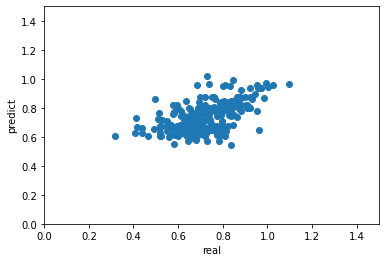

In [ ]:
# 예측값과 실제값의 시각화
plt.scatter(y_test, stack_final)
plt.xlabel("real")
plt.ylabel("predict")
plt.xlim(0,1.5)
plt.ylim(0,1.5)

In [110]:
predict = result[result['시즌']==2022] # 2018년도 데이터 프레임
predict = pd.concat([predict, pd.get_dummies(predict['포지션'], drop_first=True)], axis=1) # 포지션 dummy variable로 변환
X = predict[X_cols] # 사용 feature
X = X.fillna(-1) # NA값 -1로 impute
predict['y_hat'] = model.predict(X)
new = ['이름','생일','팀','시즌','포지션','y_hat']
# 타자별 예측값 feature에 저장
final = predict[new]
# 제출 파일 생성
final.to_csv("/content/tnt_submission.csv", index=False, encoding='utf-8')
# 제출 결과 확인
sub = pd.read_csv('/content/tnt_submission.csv')
sub

ValueError: ignored

In [133]:
test2['y_hat'] = stack_final
test2 = test2[test2['시즌']==2022]

predict = result[result['시즌']==2022] # 2018년도 데이터 프레임



predict['y_hat'] = test2['y_hat']
new = ['이름','생일','팀','시즌','포지션','y_hat']
# 타자별 예측값 feature에 저장
final = predict[new]
# 제출 파일 생성
final.to_csv("/content/tnt_submission.csv", index=False, encoding='utf-8')
# 제출 결과 확인
sub = pd.read_csv('/content/tnt_submission.csv')
sub

<ipython-input-133-11ce85d8c9d2>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict['y_hat'] = test2['y_hat']


,이름,생일,팀,시즌,포지션,y_hat
0,이정후,1998-08-20,키,2022,CF,NaN
1,피렐라,1989-11-21,삼,2022,LF,NaN
2,나성범,1989-10-03,K,2022,RF,NaN
3,오지환,1990-03-12,L,2022,SS,NaN
4,최정,1987-02-28,S,2022,3B,NaN
...,...,...,...,...,...,...
181,조세진,2003-11-21,롯,2022,RF,NaN
182,유로결,2000-05-30,한,2022,LF,NaN
183,정보근,1999-08-31,롯,2022,C,NaN
184,박경수,1984-03-31,K,2022,2B,NaN
